In [1]:
!pip install tensorflow faiss

### Prepare the dataset

In [3]:
import numpy as np
from tensorflow import keras

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(x_train.shape)

mnist = x_train.reshape(60000, 28*28)
mnist.shape

(60000, 28, 28)


(60000, 784)

### Test the index

In [4]:
import time
import faiss

faiss.omp_set_num_threads(1)

In [9]:
d = mnist.shape[1]
M = 64

HNSW = faiss.IndexHNSWFlat(d, M)
HNSW.hnsw.efConstruction = 64
HNSW.add(mnist)

D, I = HNSW.search(mnist[40].reshape(1, mnist.shape[1]), 100)
print(I)

flat = faiss.IndexFlatL2(mnist.shape[1])
flat.add(mnist)

D, FLAT_I = flat.search(mnist[40].reshape(1, mnist.shape[1]), k=100) 
print(FLAT_I)

[[   40 19446 34359 47434 34613 50709 17928  3604  3714  3418 44210 57855
  45366 32765  5530 49512 18741 33992 18852 15786 45220  6665   838 37518
  43770 46984  9161 49440 34426 25822 36240 20810 40694 31045  2762 23492
  47440 30337 56559  8166 29666 49964 36968 40864 39095 21379  4772 44158
  55080  1910 34423 46507 11178 48444 37014 16932  9173 12436 56192 49876
  15380 32979 14126 52362  8602 37948 11412  4766 26960 18389 16345 17711
  30209 56980 40140 31916 53436 12952 35108 50842 54816  7060 23396 40516
  32859 41852  4070 41640 27028 45693 33942 45926 43286 25899 44556 46470
  54611 38463 17942 56696]]
[[   40 19446 34359 47434 34613 50709 17928  3604  3714  3418 44210 57855
  45366 32765  5530 49512 18741 33992 18852 15786 45220  6665   838 37518
  43770 46984  9161 49440 34426 25822 36240 20810 40694 31045  2762 23492
  47440 30337 56559  8166 29666 49964 36968 40864 39095 21379  4772 14234
  44158 55080  1910 34423 46507 11178 48444 37014 16932  9173 12436 56192
  49876 15

In [10]:
# Calculate the recall
I = I.flatten()
FLAT_I = FLAT_I.flatten()
sum([1 for i in I if i in FLAT_I])

96

In [11]:
from faiss import write_index
write_index(HNSW, 'save/HNSW-M64.index')

### Benchmark

In [12]:
import time

M = [ 16, 24, 32, 48, 64, 128, 256]
indexes =[]
build_time=[]

def build_index(data, M):
    index = faiss.IndexHNSWFlat(d, M)
    index.hnsw.efConstruction = 64
    index.add(data)
    return index

for m in M:
    start = time.time()
    index = build_index(mnist, M=m)
    btime = time.time() - start
    build_time.append(btime)
    indexes.append(index)

print(build_time)

[13.872749090194702, 13.666279792785645, 14.736966371536255, 24.642167329788208, 26.63881540298462, 31.717292308807373, 37.51683974266052]


In [13]:
def recall(pred, true):
    return sum([1 for i in pred if i in true]) / true.size

def benchmark_knn_query(data, indexes, size=1000, k=100):
    result = []

    indices = np.random.choice(data.shape[0], size, replace=False)
    for index in indexes:
        query_time = 0
        cur_recall = 0

        # query
        for i in indices:
            start = time.time()
            D, I = index.search(data[i].reshape(1, data.shape[1]), k=k)
            query_time += (time.time() - start)
            D, FLAT_I = flat.search(data[i].reshape(1, data.shape[1]), k=k) 
            cur_recall += recall(I.flatten(), FLAT_I.flatten())
        
        result.append((query_time/1000, cur_recall/1000))

    return result

result = benchmark_knn_query(mnist, indexes) 
print(result)  

[(0.0001421358585357666, 0.7444799999999996), (0.00016962289810180665, 0.7622399999999989), (0.00016873502731323242, 0.7645999999999988), (0.00025153613090515137, 0.9516100000000085), (0.000266934871673584, 0.9722800000000064), (0.0004488632678985596, 0.9798500000000044), (0.0005174827575683594, 0.9812300000000045)]


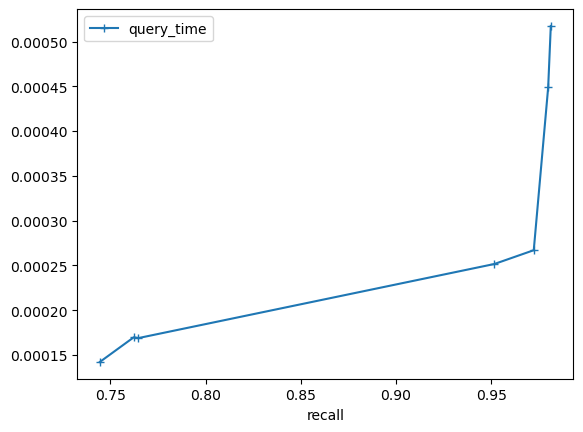

In [14]:
import pandas as pd

df = pd.DataFrame(result, columns=['query_time', 'recall'])
df.plot(x='recall', y='query_time',style='+-')

import os  
os.makedirs('results', exist_ok=True)
df.to_csv('results/HNSW-mnist.csv')